In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(4,4)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    
    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

In [4]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]

    def random_op(self):
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
        
        batch_size=len(input)
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        #print(V_output.size())
        #Q_grid, K_grid=torch.meshgrid(Q_output, K_output, indexing='ij')
        alpha=torch.exp(-(Q_output-K_output)**2)
        alpha=alpha.transpose(0,1)
        print(f'alpha: {alpha}')
        # Example usage:
        visualize_attention(alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        print("Q_output size:", Q_output.size())
        print("K_output size:", K_output.size())
        print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 1)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d

digits = load_digits()
X, y = digits.images, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train_mask = np.isin(y_train, [1, 7])
X_train, y_train = X_train[train_mask], y_train[train_mask]

test_mask = np.isin(y_test, [1, 7])
X_test, y_test = X_test[test_mask], y_test[test_mask]

#
# X_train = X_train.reshape(X_train.shape[0], 16, 4)
# X_test = X_test.reshape(X_test.shape[0], 16, 4)

In [6]:
X_train.shape

(283, 8, 8)

In [7]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [8]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [9]:
# (283, 16, 2, 2)를 (283, 16, 4)로 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [10]:
# # 이미지 패치 나누기 (2x2 크기 패치)
# patch_size = (2, 2)

# # 각 이미지를 개별적으로 패치로 나누기
# X_train = np.array([extract_patches_2d(img, patch_size) for img in X_train])
# X_test = np.array([extract_patches_2d(img, patch_size) for img in X_test])

In [11]:
X_train.shape

(283, 4, 16)

In [12]:
X_train

array([[[ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [16., 16., 13., ..., 11.,  1.,  0.],
        [ 0.,  0.,  2., ...,  0.,  2., 15.],
        [15., 16.,  9., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  4., ...,  0.,  1.,  9.],
        [16., 11.,  0., ..., 16., 10.,  0.],
        [ 0.,  0., 13., ...,  0.,  6., 11.],
        [16.,  8.,  2., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  6., ...,  2.,  6., 12.],
        [14.,  1.,  0., ...,  7.,  2.,  0.],
        [ 0., 13., 16., ...,  0., 10.,  8.],
        [16., 16.,  9., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  3., 15., ...,  0., 11., 13.],
        [15.,  3.,  0., ..., 16.,  8.,  0.],
        [ 0.,  1., 15., ...,  3., 16.,  5.],
        [15.,  7.,  2., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  7., 12.,  0.],
        [16., 10.,  0., ..., 11.,  0.,  0.],
        [ 0.,  1.,  2., ...,  0.,  1., 15.],
        [15., 16.,  7., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  0.,  9., 16.],
        [11.,  1.,  0., ...,  0.

In [13]:
    # def circuit_v(self,inputs,weights):
    #         op=self.random_op()
    #         # feature_map
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(inputs[indx],j)
    #             qml.RY(inputs[indx+1],j)
    #             indx+=2
    #         for i in range(self.Denc):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))

    #             for j in range(self.num_q):
    #                 qml.RY(inputs[indx],j)
    #                 indx+=1
    #         # Ansatz
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(weights[indx],j)
    #             qml.RY(weights[indx+1],j)
    #             indx+=2
    #         for i in range(self.D):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
    #             for j in range(self.num_q):
    #                 #qc.rx(params[indx],j)
    #                 qml.RY(weights[indx],j)
    #                 indx+=1
    #         return [qml.expval(op) for i in range(self.d)] 

In [14]:
model=QSANN_text_classifier(4, 4, 2, 1, 1)

# seq * (num_qubits) * (num_layers + 2)

In [15]:
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

In [16]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

209


In [17]:
criterion = torch.nn.CrossEntropyLoss()

In [18]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [19]:
torch.tensor(X_train)

tensor([[[ 0.,  0.,  3.,  ...,  0.,  0.,  0.],
         [16., 16., 13.,  ..., 11.,  1.,  0.],
         [ 0.,  0.,  2.,  ...,  0.,  2., 15.],
         [15., 16.,  9.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  4.,  ...,  0.,  1.,  9.],
         [16., 11.,  0.,  ..., 16., 10.,  0.],
         [ 0.,  0., 13.,  ...,  0.,  6., 11.],
         [16.,  8.,  2.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  6.,  ...,  2.,  6., 12.],
         [14.,  1.,  0.,  ...,  7.,  2.,  0.],
         [ 0., 13., 16.,  ...,  0., 10.,  8.],
         [16., 16.,  9.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  3., 15.,  ...,  0., 11., 13.],
         [15.,  3.,  0.,  ..., 16.,  8.,  0.],
         [ 0.,  1., 15.,  ...,  3., 16.,  5.],
         [15.,  7.,  2.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  ...,  7., 12.,  0.],
         [16., 10.,  0.,  ..., 11.,  0.,  0.],
         [ 0.,  1.,  2.,  ...,  0.,  1., 15.],
         [15., 16.,  7.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  ...,  0., 

  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([283, 4, 16])
alpha: tensor([[[0.9269, 0.6156, 0.9278, 0.9828],
         [0.9740, 0.9352, 0.9735, 0.7232],
         [0.9997, 0.8242, 0.9997, 0.8599],
         [0.9695, 0.9416, 0.9689, 0.7119]],

        [[0.7995, 0.9668, 0.9976, 0.9480],
         [0.9837, 0.9743, 0.9159, 0.9871],
         [0.9572, 0.9936, 0.9547, 0.9989],
         [0.8713, 0.9933, 0.9972, 0.9835]],

        [[0.9894, 0.9875, 0.9998, 0.9884],
         [0.9065, 0.9015, 0.9515, 0.9040],
         [0.9226, 0.9271, 0.8694, 0.9249],
         [0.9985, 0.9978, 0.9973, 0.9981]],

        ...,

        [[0.9877, 0.9993, 0.7575, 0.9950],
         [0.7095, 0.6380, 0.9714, 0.6753],
         [0.9692, 0.9339, 0.9446, 0.9537],
         [0.9807, 0.9970, 0.7348, 0.9903]],

        [[0.9061, 0.9800, 0.9532, 0.9978],
         [0.6013, 0.7459, 0.6824, 0.8834],
         [0.9137, 0.9835, 0.9587, 0.9963],
         [0.7925, 0.9080, 0.8607, 0.9854]],

        [[0.9949, 0.9765, 0.8146, 0.8309],
         [0.7467, 0.8110, 0.9750, 0.9676]

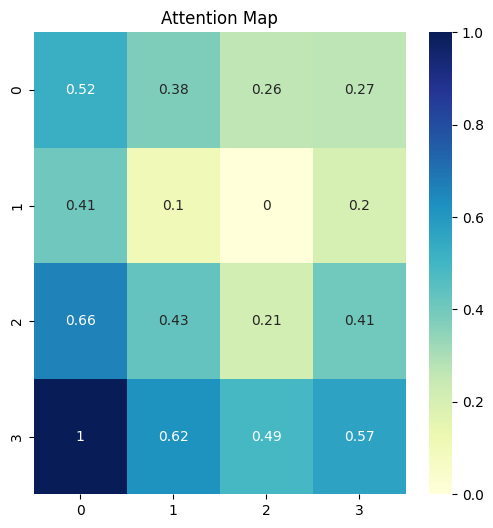

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.5901)

tensor(778.0195, grad_fn=<DivBackward1>)


  3%|▎         | 1/30 [01:28<42:35, 88.12s/it]

Complete 0 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9957, 0.8674, 0.9888, 0.8669],
         [0.7118, 0.9289, 0.7451, 0.9293],
         [0.9803, 0.8149, 0.9676, 0.8143],
         [0.9989, 0.8882, 0.9946, 0.8877]],

        [[0.9916, 0.8700, 0.8069, 0.9889],
         [0.9578, 0.9945, 0.9735, 0.9632],
         [0.9906, 0.9665, 0.9274, 0.9931],
         [0.9790, 0.9817, 0.9503, 0.9828]],

        [[0.8872, 0.8685, 0.7082, 0.8906],
         [0.8726, 0.8531, 0.6888, 0.8762],
         [0.9387, 0.9518, 0.9999, 0.9359],
         [0.9949, 0.9898, 0.9066, 0.9957]],

        ...,

        [[0.6839, 0.7833, 0.8965, 0.7666],
         [0.9237, 0.8495, 0.7246, 0.8638],
         [0.9914, 0.9992, 0.9635, 0.9999],
         [0.9847, 1.0000, 0.9742, 0.9995]],

        [[0.9666, 0.8925, 0.9463, 0.9038],
         [0.8565, 0.7417, 0.8208, 0.7571],
         [0.9944, 0.9939, 0.9994, 0.9965],
         [0.9833, 0.9231, 0.9679, 0.9328]],

        [[0.9984, 0.8736, 0.7533, 0.9912],
         [0.9751, 0.7895, 0.6548, 0.9559],
         [0.9990, 0.916

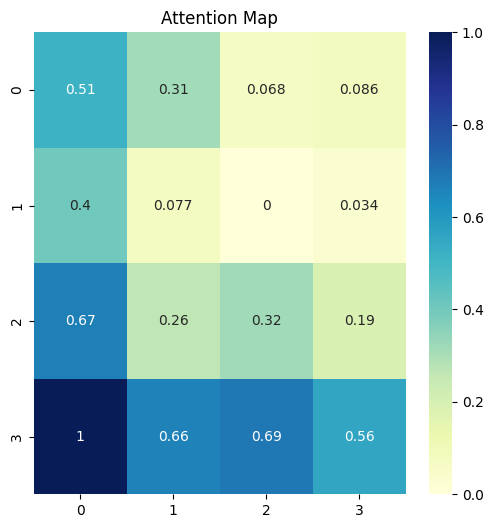

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.6219)

tensor(767.3164, grad_fn=<DivBackward1>)


  7%|▋         | 2/30 [02:55<40:48, 87.46s/it]

Complete 1 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9910, 0.9442, 0.9895, 0.9357],
         [0.9863, 0.9336, 0.9845, 0.9461],
         [0.9754, 0.9126, 0.9730, 0.9627],
         [0.9737, 0.9095, 0.9713, 0.9647]],

        [[0.9805, 0.9984, 0.9393, 0.9280],
         [0.9986, 0.9960, 0.9787, 0.9716],
         [0.9979, 0.9791, 0.9959, 0.9924],
         [0.9624, 0.9163, 0.9926, 0.9960]],

        [[0.9807, 0.9716, 0.8963, 0.9725],
         [0.8604, 0.8800, 0.9622, 0.8782],
         [0.9063, 0.9228, 0.9852, 0.9213],
         [0.9984, 0.9950, 0.9476, 0.9954]],

        ...,

        [[0.8427, 0.6152, 0.9540, 0.7918],
         [0.9578, 0.7857, 0.9999, 0.9260],
         [0.9998, 0.9158, 0.9669, 0.9932],
         [0.9924, 0.9623, 0.9225, 0.9997]],

        [[0.9872, 0.9666, 0.9848, 0.6406],
         [0.6294, 0.5688, 0.6205, 0.2180],
         [0.9671, 0.9875, 0.9707, 0.8714],
         [0.6666, 0.7257, 0.6753, 0.9931]],

        [[0.8404, 0.8718, 0.9742, 0.8875],
         [1.0000, 0.9980, 0.7167, 0.9951],
         [0.8966, 0.922

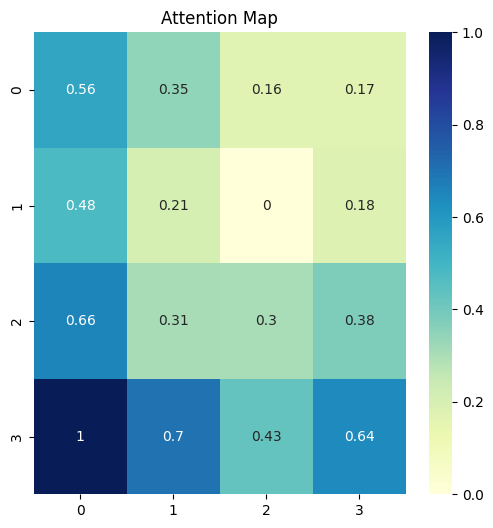

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.7633)

tensor(756.1251, grad_fn=<DivBackward1>)


 10%|█         | 3/30 [04:30<40:59, 91.08s/it]

Complete 2 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8617, 0.9899, 0.8779, 0.8217],
         [0.9852, 0.8473, 0.9787, 0.9958],
         [0.9793, 0.9804, 0.9857, 0.9600],
         [0.9724, 0.8148, 0.9637, 0.9880]],

        [[0.9804, 0.9240, 0.8620, 0.9450],
         [0.9964, 0.9605, 0.9111, 0.9755],
         [0.9977, 0.9915, 0.9621, 0.9976],
         [0.9748, 0.9138, 0.8490, 0.9360]],

        [[0.9461, 0.8229, 0.9763, 0.9651],
         [0.9232, 0.9941, 0.6357, 0.8971],
         [0.8623, 0.9685, 0.5483, 0.8299],
         [0.9989, 0.9441, 0.8806, 0.9998]],

        ...,

        [[0.9796, 0.9145, 0.8170, 0.8753],
         [0.8665, 0.7519, 0.6258, 0.6976],
         [0.9826, 0.9995, 0.9704, 0.9921],
         [0.9845, 0.9991, 0.9678, 0.9907]],

        [[0.7296, 0.7427, 0.7643, 0.4759],
         [0.9995, 0.9985, 0.9957, 0.9257],
         [0.9766, 0.9812, 0.9878, 0.8137],
         [0.8352, 0.8464, 0.8647, 0.5915]],

        [[0.9180, 0.9292, 0.9838, 0.9091],
         [0.9984, 0.9961, 0.9587, 0.9994],
         [0.9997, 0.998

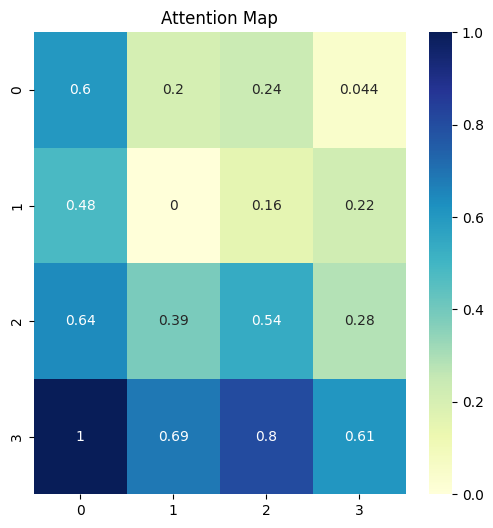

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8799)

tensor(744.7840, grad_fn=<DivBackward1>)


 13%|█▎        | 4/30 [06:05<40:04, 92.50s/it]

Complete 3 th
torch.Size([283, 4, 16])
alpha: tensor([[[0.9543, 0.9520, 0.9602, 0.9215],
         [0.9643, 0.9406, 0.9695, 0.9345],
         [1.0000, 0.8282, 0.9999, 0.9946],
         [0.9896, 0.7468, 0.9864, 0.9989]],

        [[0.9997, 0.9187, 0.9879, 0.9956],
         [0.9768, 0.9758, 0.9994, 0.9954],
         [0.9559, 0.9906, 0.9930, 0.9839],
         [0.9986, 0.9289, 0.9918, 0.9978]],

        [[0.9541, 0.8940, 0.8197, 0.9877],
         [0.8433, 0.7544, 0.6623, 0.9099],
         [0.8301, 0.7394, 0.6464, 0.8992],
         [0.9998, 0.9895, 0.9553, 0.9855]],

        ...,

        [[0.7694, 0.7784, 0.3078, 0.9378],
         [0.7544, 0.7452, 0.9982, 0.5362],
         [0.8784, 0.8855, 0.4183, 0.9897],
         [0.9559, 0.9604, 0.5392, 0.9979]],

        [[0.9324, 0.8650, 0.8846, 0.6402],
         [0.9149, 0.9674, 0.9558, 0.9890],
         [0.9000, 0.8234, 0.8452, 0.5888],
         [0.9380, 0.8725, 0.8917, 0.6501]],

        [[0.9949, 0.9912, 0.8623, 0.9722],
         [0.9985, 0.9962, 0

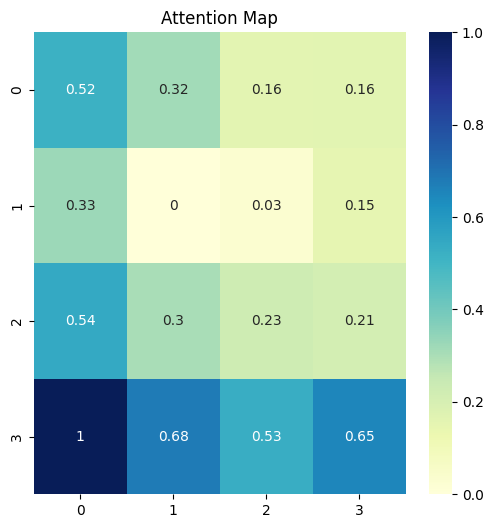

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9152)

tensor(739.3782, grad_fn=<DivBackward1>)


 17%|█▋        | 5/30 [07:36<38:22, 92.10s/it]

Complete 4 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9979, 0.9044, 0.9981, 0.9631],
         [0.9444, 0.7709, 0.9455, 0.8609],
         [0.9993, 0.9418, 0.9992, 0.9853],
         [0.9704, 0.8209, 0.9712, 0.9020]],

        [[0.9209, 0.8567, 0.9433, 0.9486],
         [0.9898, 0.9579, 0.9969, 0.9981],
         [0.9997, 0.9921, 0.9960, 0.9944],
         [0.9996, 0.9928, 0.9956, 0.9939]],

        [[0.9965, 0.9972, 0.8168, 0.9968],
         [0.8718, 0.7921, 0.9996, 0.8699],
         [0.9882, 0.9523, 0.9236, 0.9876],
         [0.9989, 0.9788, 0.8805, 0.9986]],

        ...,

        [[0.7623, 0.9707, 0.6733, 0.9098],
         [0.9578, 0.7341, 0.9901, 0.8375],
         [0.9997, 0.8756, 0.9916, 0.9486],
         [0.9415, 0.9895, 0.8826, 0.9990]],

        [[0.9953, 0.9508, 0.9497, 0.9885],
         [0.9839, 0.9992, 0.9990, 0.9922],
         [0.9628, 0.8843, 0.8827, 0.9469],
         [0.9404, 0.8495, 0.8478, 0.9210]],

        [[0.9549, 0.8716, 0.9705, 0.7275],
         [0.7816, 0.8905, 0.7485, 0.9785],
         [0.7547, 0.869

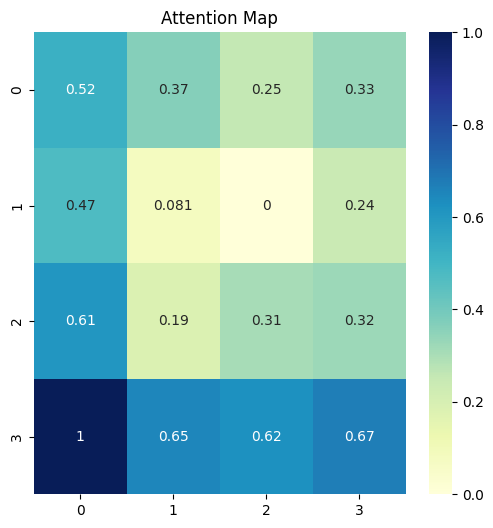

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9293)

tensor(737.1066, grad_fn=<DivBackward1>)


 20%|██        | 6/30 [09:07<36:40, 91.68s/it]

Complete 5 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9412, 0.7856, 0.9821, 0.9998],
         [0.9486, 0.7982, 0.9861, 1.0000],
         [0.9921, 0.8943, 0.9995, 0.9802],
         [0.9998, 0.9353, 0.9905, 0.9541]],

        [[0.9940, 0.7751, 0.9552, 0.8749],
         [0.9867, 0.9075, 0.9996, 0.9708],
         [0.9734, 0.9333, 0.9992, 0.9849],
         [0.9735, 0.9331, 0.9992, 0.9848]],

        [[0.9104, 0.9866, 1.0000, 0.9568],
         [0.9644, 0.8652, 0.7779, 0.9211],
         [0.9613, 0.8597, 0.7715, 0.9167],
         [1.0000, 0.9626, 0.9051, 0.9898]],

        ...,

        [[0.9704, 0.9608, 0.9492, 0.9314],
         [0.6202, 0.6432, 0.3030, 0.6995],
         [0.9937, 0.9888, 0.9014, 0.9706],
         [0.9794, 0.9863, 0.7423, 0.9974]],

        [[0.9008, 0.9502, 0.9831, 0.9201],
         [0.9882, 0.9584, 0.9129, 0.9795],
         [0.8799, 0.9343, 0.9732, 0.9009],
         [0.9699, 0.9288, 0.8736, 0.9571]],

        [[0.9294, 0.8937, 0.9857, 0.9720],
         [0.9527, 0.9761, 0.6887, 0.9013],
         [0.9657, 0.985

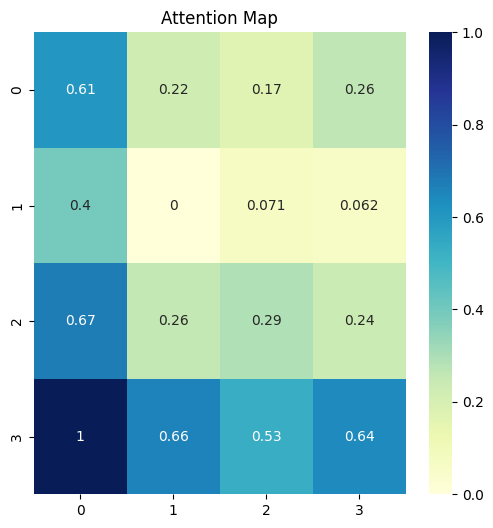

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9576)

tensor(733.7899, grad_fn=<DivBackward1>)


 23%|██▎       | 7/30 [10:38<35:01, 91.36s/it]

Complete 6 th
torch.Size([283, 4, 16])
alpha: tensor([[[0.9778, 0.6658, 0.9883, 0.9631],
         [0.9964, 0.7408, 0.9997, 0.9226],
         [0.9953, 0.8386, 0.9880, 0.8438],
         [0.9967, 0.8309, 0.9903, 0.8513]],

        [[0.8721, 0.9959, 0.8370, 0.9739],
         [0.9830, 0.9122, 0.9671, 0.9942],
         [0.9726, 0.9310, 0.9533, 0.9984],
         [0.9997, 0.8413, 0.9951, 0.9650]],

        [[0.9199, 0.9453, 0.7137, 0.9442],
         [0.9587, 0.9767, 0.7809, 0.9759],
         [0.9176, 0.8878, 1.0000, 0.8892],
         [0.9978, 1.0000, 0.8918, 1.0000]],

        ...,

        [[0.9242, 0.7875, 0.7025, 0.7474],
         [0.9223, 0.7848, 0.6996, 0.7445],
         [0.9921, 0.9157, 0.8506, 0.8862],
         [0.9639, 0.9997, 0.9853, 0.9955]],

        [[0.8095, 0.6853, 0.7658, 0.4641],
         [0.4809, 0.3601, 0.4349, 0.1982],
         [0.9997, 0.9813, 0.9985, 0.8529],
         [0.7927, 0.8986, 0.8347, 0.9957]],

        [[0.8188, 0.8460, 0.6222, 0.9691],
         [0.9805, 0.9686, 0

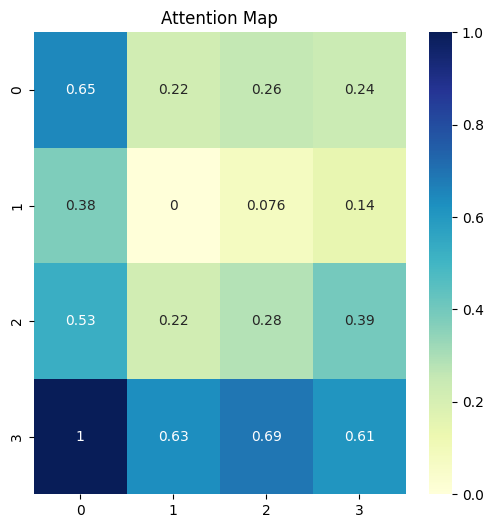

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9682)

tensor(730.9236, grad_fn=<DivBackward1>)


 27%|██▋       | 8/30 [12:07<33:15, 90.73s/it]

Complete 7 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9952, 0.9017, 0.9826, 0.9522],
         [0.9870, 0.9265, 0.9689, 0.9313],
         [0.9980, 0.8873, 0.9884, 0.9619],
         [0.9785, 0.7486, 0.9930, 1.0000]],

        [[0.7745, 0.8430, 0.8951, 0.9046],
         [0.9404, 0.9760, 0.9943, 0.9965],
         [0.9862, 0.9994, 0.9970, 0.9950],
         [0.8607, 0.9166, 0.9549, 0.9613]],

        [[0.9947, 1.0000, 0.9713, 0.9952],
         [0.9655, 0.9352, 0.9921, 0.9643],
         [0.9331, 0.8941, 0.9732, 0.9315],
         [0.9963, 0.9999, 0.9749, 0.9966]],

        ...,

        [[0.8450, 0.9062, 0.5185, 0.9524],
         [0.9280, 0.8722, 0.9841, 0.8072],
         [0.9462, 0.9810, 0.6681, 0.9979],
         [0.9840, 0.9991, 0.7574, 0.9961]],

        [[0.9955, 0.9946, 0.9942, 0.8498],
         [0.7223, 0.7278, 0.6012, 0.3385],
         [0.9570, 0.9542, 0.9955, 0.9343],
         [0.9491, 0.9520, 0.8711, 0.6136]],

        [[0.7716, 0.6624, 0.9421, 0.8606],
         [0.9127, 0.8277, 0.9986, 0.9679],
         [0.8009, 0.694

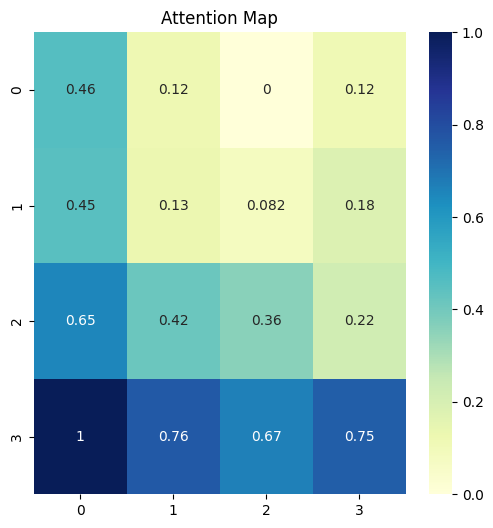

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9788)

tensor(729.2262, grad_fn=<DivBackward1>)


 30%|███       | 9/30 [13:35<31:26, 89.83s/it]

Complete 8 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9747, 0.9907, 0.9589, 0.7808],
         [0.9952, 1.0000, 0.9870, 0.8473],
         [0.9833, 0.9956, 0.9699, 0.8039],
         [0.9864, 0.9971, 0.9741, 0.8133]],

        [[0.9690, 0.9194, 0.9801, 0.9648],
         [0.9918, 0.9596, 0.9970, 0.9895],
         [0.9991, 0.9934, 0.9956, 0.9996],
         [0.9993, 0.9927, 0.9961, 0.9998]],

        [[0.9517, 0.9653, 0.6981, 0.9803],
         [0.9448, 0.9281, 0.9810, 0.9028],
         [0.9546, 0.9393, 0.9743, 0.9157],
         [0.9962, 0.9993, 0.8251, 0.9996]],

        ...,

        [[0.9830, 0.7982, 0.4349, 0.9590],
         [0.8443, 0.5652, 0.2409, 0.7902],
         [0.7527, 0.9649, 0.9400, 0.8100],
         [0.9778, 0.9630, 0.6708, 0.9943]],

        [[0.8246, 0.7397, 0.7677, 0.7750],
         [0.9745, 0.9974, 0.9926, 0.9910],
         [0.9742, 0.9289, 0.9455, 0.9496],
         [0.9991, 0.9808, 0.9892, 0.9910]],

        [[0.7751, 0.8273, 0.8882, 0.8818],
         [1.0000, 0.9953, 0.9747, 0.9779],
         [0.6512, 0.709

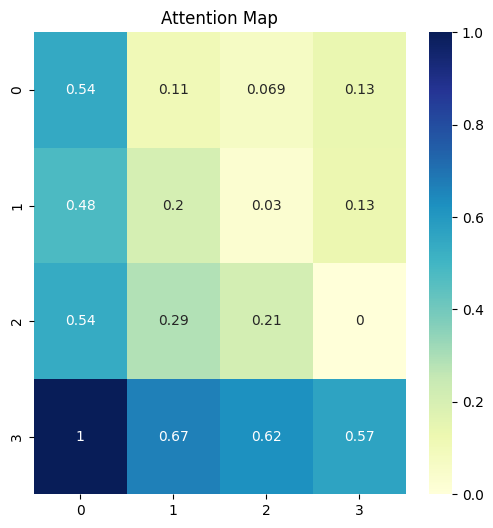

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9823)

tensor(728.5880, grad_fn=<DivBackward1>)


 33%|███▎      | 10/30 [15:03<29:43, 89.15s/it]

Complete 9 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8972, 0.6168, 0.9420, 0.9767],
         [0.7369, 0.4303, 0.8036, 0.8676],
         [0.9950, 0.8268, 0.9998, 0.9890],
         [0.9831, 0.9461, 0.9547, 0.9106]],

        [[0.9165, 0.9886, 0.9264, 0.9628],
         [0.9957, 0.9375, 0.9929, 0.9728],
         [0.9996, 0.9572, 0.9984, 0.9854],
         [0.9980, 0.9470, 0.9960, 0.9791]],

        [[0.9625, 0.9618, 0.8696, 0.9900],
         [0.9168, 0.9159, 0.7995, 0.9609],
         [0.9268, 0.9259, 0.8137, 0.9679],
         [0.9915, 0.9912, 0.9295, 1.0000]],

        ...,

        [[0.9910, 0.9614, 0.8895, 0.9857],
         [0.8951, 0.8268, 0.7144, 0.8799],
         [0.9978, 0.9779, 0.9175, 0.9950],
         [0.9837, 0.9994, 0.9860, 0.9894]],

        [[0.8240, 0.6960, 0.9963, 0.7737],
         [0.5018, 0.3736, 0.8973, 0.4474],
         [0.9984, 0.9852, 0.7465, 0.9993],
         [0.9122, 0.9802, 0.5236, 0.9455]],

        [[0.8370, 0.7333, 0.4932, 0.7990],
         [0.9850, 0.9357, 0.7457, 0.9700],
         [0.9772, 0.920

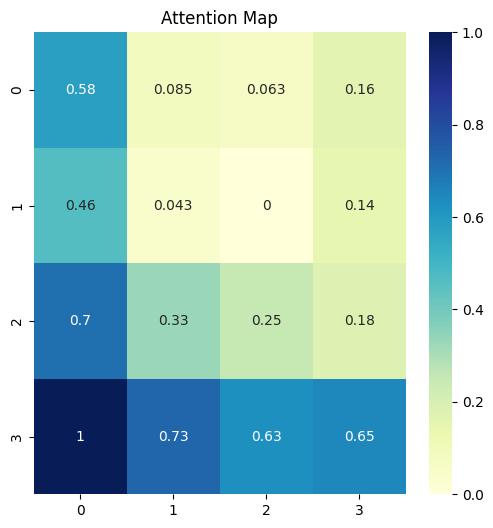

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9859)

tensor(728.3580, grad_fn=<DivBackward1>)


 37%|███▋      | 11/30 [16:30<28:05, 88.73s/it]

Complete 10 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[1.0000, 0.9467, 0.9922, 0.8995],
         [0.9394, 0.9999, 0.9764, 0.7236],
         [0.9703, 0.9955, 0.9939, 0.7848],
         [0.9996, 0.9528, 0.9945, 0.8910]],

        [[1.0000, 0.9628, 0.9433, 0.9915],
         [0.9899, 0.9922, 0.9819, 0.9998],
         [0.9816, 0.9972, 0.9901, 0.9976],
         [0.8846, 0.9744, 0.9871, 0.9331]],

        [[0.9714, 0.9559, 0.9712, 0.9724],
         [0.9385, 0.9171, 0.9921, 0.9399],
         [0.9324, 0.9101, 0.9941, 0.9338],
         [0.9988, 0.9999, 0.8681, 0.9986]],

        ...,

        [[0.9651, 0.9916, 0.6250, 0.9990],
         [0.7217, 0.6405, 0.9945, 0.5346],
         [0.9659, 0.9919, 0.6268, 0.9988],
         [0.9826, 0.9987, 0.6728, 0.9923]],

        [[0.7274, 0.6241, 0.7470, 0.5942],
         [0.9309, 0.9792, 0.9185, 0.9879],
         [0.9552, 0.9916, 0.9448, 0.9968],
         [0.9845, 1.0000, 0.9781, 0.9989]],

        [[0.8761, 0.9154, 0.9451, 0.9750],
         [0.9348, 0.9633, 0.9823, 0.9970],
         [0.8834, 0.921

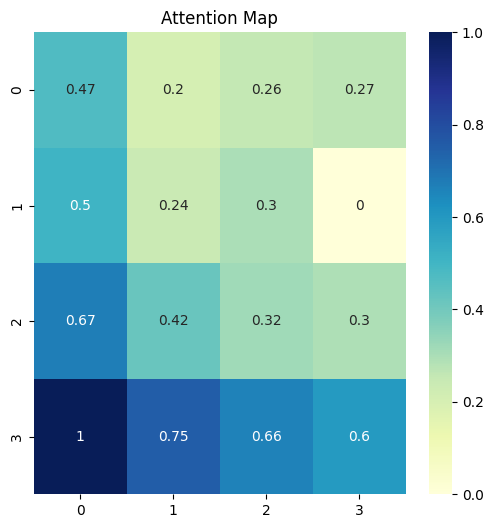

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9894)

tensor(727.9730, grad_fn=<DivBackward1>)


 40%|████      | 12/30 [18:00<26:40, 88.91s/it]

Complete 11 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9918, 0.9571, 0.9999, 0.9627],
         [0.7120, 0.8065, 0.6458, 0.7955],
         [0.9830, 0.9999, 0.9571, 0.9993],
         [0.9733, 0.9228, 0.9926, 0.9302]],

        [[0.9553, 0.9967, 0.9592, 0.9797],
         [0.9922, 0.9954, 0.9939, 0.9997],
         [0.9999, 0.9787, 1.0000, 0.9963],
         [0.9796, 0.9142, 0.9768, 0.9552]],

        [[0.9981, 0.9975, 0.8625, 0.9994],
         [0.9687, 0.9667, 0.7641, 0.9755],
         [0.9780, 0.9763, 0.7869, 0.9836],
         [0.9993, 0.9996, 0.9064, 0.9977]],

        ...,

        [[0.7929, 0.8897, 0.8450, 0.8629],
         [0.6078, 0.7261, 0.6688, 0.6911],
         [0.9988, 0.9698, 0.9887, 0.9825],
         [0.9757, 0.9997, 0.9927, 0.9965]],

        [[0.8361, 0.9664, 0.8242, 0.9541],
         [0.5771, 0.7764, 0.5629, 0.7511],
         [0.9999, 0.9392, 1.0000, 0.9534],
         [0.9751, 0.9937, 0.9697, 0.9977]],

        [[0.7736, 0.7646, 0.9920, 0.8734],
         [0.9982, 0.9972, 0.8686, 0.9907],
         [0.7217, 0.712

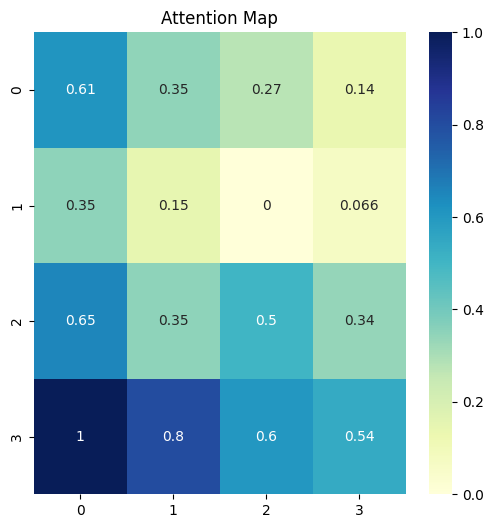

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9894)

tensor(727.4258, grad_fn=<DivBackward1>)


 43%|████▎     | 13/30 [19:30<25:18, 89.32s/it]

Complete 12 th
torch.Size([283, 4, 16])
alpha: tensor([[[0.9484, 0.9999, 0.9429, 0.8629],
         [0.9568, 0.9998, 0.9517, 0.8760],
         [0.9752, 0.9958, 0.9713, 0.9072],
         [0.9967, 0.9730, 0.9951, 0.9563]],

        [[0.9842, 0.9767, 0.9876, 0.9557],
         [0.9997, 0.9981, 0.9522, 0.9894],
         [0.9942, 0.9893, 0.9742, 0.9738],
         [0.9760, 0.9671, 0.9932, 0.9430]],

        [[0.9941, 0.9980, 0.8072, 0.9958],
         [0.8877, 0.8672, 0.9983, 0.8806],
         [0.9184, 0.9349, 0.6315, 0.9244],
         [0.9997, 0.9974, 0.8736, 0.9991]],

        ...,

        [[0.9331, 0.9481, 0.9705, 0.9806],
         [0.6678, 0.6951, 0.9610, 0.7691],
         [0.9765, 0.9852, 0.9237, 0.9990],
         [0.9481, 0.9613, 0.9588, 0.9884]],

        [[0.9773, 0.9672, 0.9983, 0.9276],
         [0.6571, 0.6305, 0.7487, 0.9517],
         [0.9780, 0.9680, 0.9985, 0.9265],
         [0.9951, 0.9985, 0.9682, 0.7824]],

        [[0.6763, 0.7990, 0.5072, 0.9228],
         [0.9785, 0.9144, 

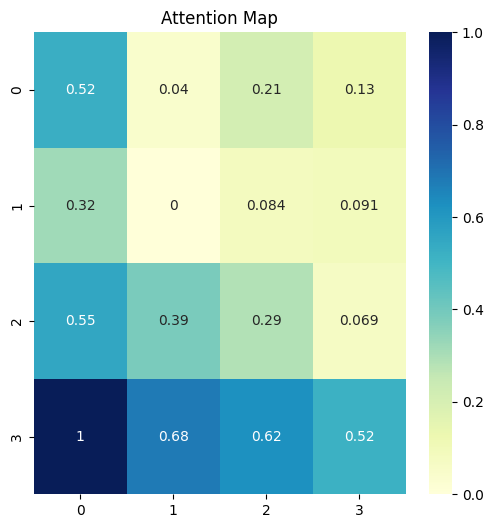

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9929)

tensor(726.8234, grad_fn=<DivBackward1>)


 47%|████▋     | 14/30 [21:00<23:51, 89.48s/it]

Complete 13 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9762, 0.7819, 0.9555, 0.9477],
         [0.7028, 0.9379, 0.7505, 0.3819],
         [0.9949, 0.9301, 0.9998, 0.8103],
         [0.9883, 0.8174, 0.9726, 0.9252]],

        [[0.9849, 0.7655, 0.7486, 0.8900],
         [0.9419, 0.9780, 0.9714, 0.9993],
         [0.9143, 0.9911, 0.9867, 0.9934],
         [1.0000, 0.8594, 0.8449, 0.9553]],

        [[0.9661, 0.8549, 0.9989, 0.9869],
         [0.9758, 0.9971, 0.9087, 0.9496],
         [0.8954, 0.7450, 0.9683, 0.9340],
         [0.9972, 0.9328, 0.9901, 0.9997]],

        ...,

        [[0.7157, 0.9287, 0.8767, 0.8726],
         [0.9227, 0.7060, 0.7794, 0.7844],
         [0.6494, 0.8843, 0.8229, 0.8182],
         [0.9377, 0.9972, 0.9985, 0.9980]],

        [[0.9103, 0.8277, 0.9643, 0.9406],
         [0.9126, 0.9701, 0.8395, 0.8775],
         [0.9402, 0.9857, 0.8758, 0.9098],
         [0.9996, 0.9881, 0.9820, 0.9939]],

        [[0.8892, 0.8556, 0.9520, 0.8491],
         [0.9603, 0.9780, 0.9014, 0.9807],
         [0.8681, 0.832

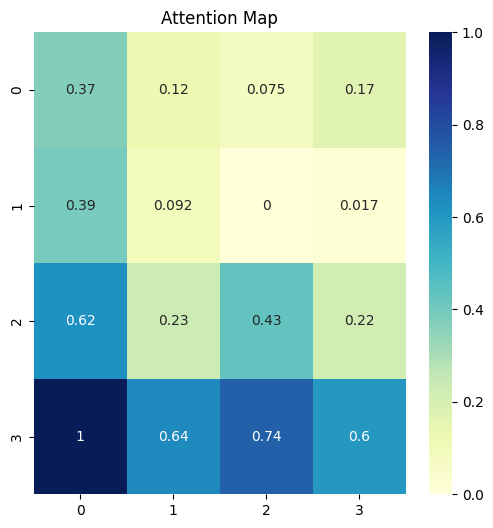

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(726.3113, grad_fn=<DivBackward1>)


 50%|█████     | 15/30 [22:29<22:21, 89.41s/it]

Complete 14 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8984, 0.9988, 0.8707, 0.7831],
         [0.9437, 0.7524, 0.9624, 0.9946],
         [0.9724, 0.9844, 0.9560, 0.8941],
         [0.9988, 0.9353, 0.9938, 0.9603]],

        [[0.9995, 1.0000, 0.8415, 0.9952],
         [0.9297, 0.9426, 0.9726, 0.9683],
         [0.9451, 0.9566, 0.9611, 0.9786],
         [0.8631, 0.8805, 0.9972, 0.9177]],

        [[0.9974, 0.9933, 0.9200, 0.9936],
         [0.8629, 0.8826, 0.9788, 0.8814],
         [0.9186, 0.9343, 0.9971, 0.9334],
         [0.9995, 0.9972, 0.9346, 0.9974]],

        ...,

        [[0.9605, 0.9208, 0.8725, 0.9707],
         [0.6685, 0.7406, 0.8048, 0.6444],
         [0.9110, 0.8576, 0.7988, 0.9261],
         [0.9972, 0.9988, 0.9866, 0.9935]],

        [[0.9987, 0.9647, 1.0000, 0.7568],
         [0.7845, 0.6589, 0.8096, 0.3796],
         [0.8224, 0.9198, 0.7977, 0.9976],
         [0.8016, 0.9044, 0.7762, 0.9995]],

        [[0.8539, 0.7494, 0.8815, 0.8015],
         [0.9058, 0.8135, 0.9285, 0.8606],
         [0.9820, 1.000

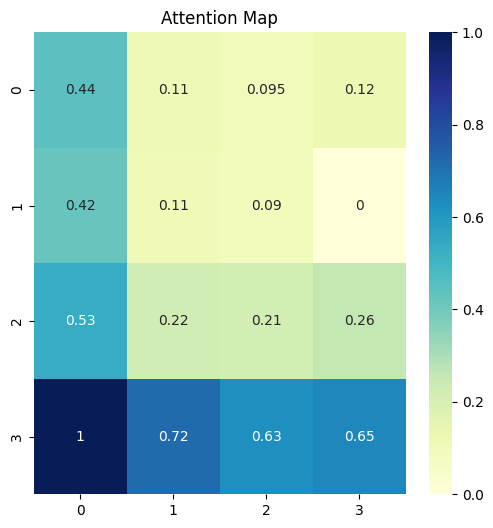

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(726.0476, grad_fn=<DivBackward1>)


 53%|█████▎    | 16/30 [24:01<21:03, 90.25s/it]

Complete 15 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9977, 0.9455, 0.9998, 0.8164],
         [0.7131, 0.9158, 0.7417, 0.3801],
         [0.9826, 0.8400, 0.9724, 0.9300],
         [0.9986, 0.9407, 1.0000, 0.8242]],

        [[0.9136, 0.7441, 0.9941, 0.9492],
         [0.9968, 0.9143, 0.9723, 0.9997],
         [0.9991, 0.9279, 0.9634, 0.9983],
         [0.9642, 0.9973, 0.8421, 0.9331]],

        [[0.9995, 0.9800, 0.8813, 1.0000],
         [0.8447, 0.7188, 0.9941, 0.8341],
         [0.8907, 0.9694, 0.6349, 0.8997],
         [0.9996, 0.9669, 0.9060, 0.9988]],

        ...,

        [[0.8805, 0.9835, 0.9680, 0.9615],
         [0.8910, 0.9876, 0.9617, 0.9677],
         [0.9965, 0.9720, 0.7958, 0.9902],
         [0.9960, 0.9734, 0.7990, 0.9910]],

        [[0.9999, 0.9888, 0.9718, 0.9947],
         [0.6883, 0.5913, 0.5374, 0.6197],
         [0.9231, 0.9718, 0.9888, 0.9599],
         [0.9275, 0.8602, 0.8157, 0.8816]],

        [[0.9975, 0.9415, 0.6338, 0.9823],
         [0.9980, 0.9773, 0.7135, 0.9984],
         [0.9787, 0.997

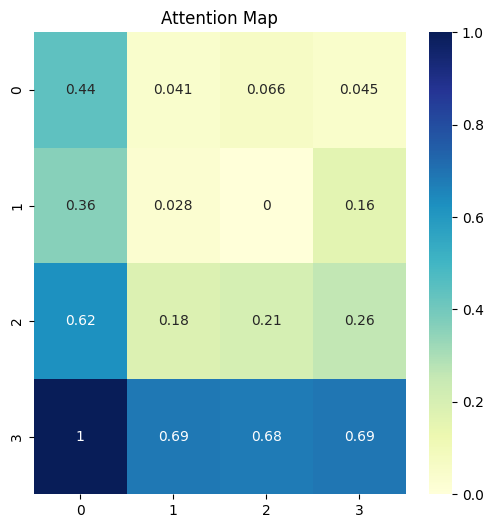

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.9120, grad_fn=<DivBackward1>)


 57%|█████▋    | 17/30 [25:30<19:26, 89.76s/it]

Complete 16 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9948, 0.9535, 0.9858, 0.8256],
         [0.9742, 0.9836, 0.9570, 0.7571],
         [0.9836, 0.9742, 0.9693, 0.7831],
         [0.9756, 0.8186, 0.9881, 0.9574]],

        [[0.9843, 0.7518, 0.9904, 0.8313],
         [0.9439, 0.9722, 0.9307, 0.9960],
         [0.9773, 0.9362, 0.9684, 0.9770],
         [0.9467, 0.9701, 0.9337, 0.9951]],

        [[0.9963, 0.9927, 0.9939, 0.9849],
         [0.8725, 0.8879, 0.7720, 0.9100],
         [0.9871, 0.9810, 0.9994, 0.9694],
         [0.9991, 0.9970, 0.9882, 0.9915]],

        ...,

        [[0.9681, 0.9102, 0.9506, 0.9502],
         [0.6492, 0.7547, 0.6875, 0.6881],
         [0.9968, 0.9670, 0.9897, 0.9896],
         [0.9864, 0.9999, 0.9948, 0.9949]],

        [[0.9605, 0.8692, 1.0000, 0.6311],
         [0.5776, 0.7248, 0.4131, 0.9330],
         [0.9997, 0.9640, 0.9676, 0.7822],
         [0.9932, 0.9363, 0.9865, 0.7304]],

        [[0.9980, 0.9999, 0.9077, 0.9999],
         [0.8636, 0.8405, 0.9864, 0.8258],
         [0.9956, 0.998

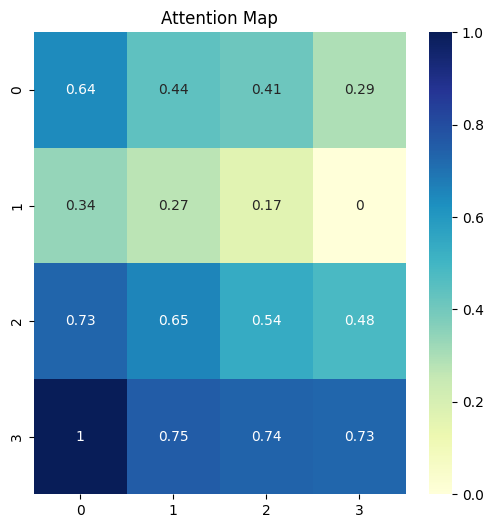

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.8475, grad_fn=<DivBackward1>)


 60%|██████    | 18/30 [26:58<17:51, 89.31s/it]

Complete 17 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9972, 0.9537, 0.9995, 0.8979],
         [0.9906, 0.9704, 0.9956, 0.9227],
         [0.9933, 0.8833, 0.9874, 0.8074],
         [1.0000, 0.9328, 0.9994, 0.8694]],

        [[0.8369, 0.9928, 0.7780, 0.8780],
         [0.9571, 0.9838, 0.9202, 0.9783],
         [0.9990, 0.9108, 0.9879, 0.9991],
         [0.9063, 0.9995, 0.8570, 0.9382]],

        [[0.9241, 0.8930, 0.9932, 0.9461],
         [0.9733, 0.9528, 0.9611, 0.9859],
         [0.9813, 0.9933, 0.7778, 0.9671],
         [0.9996, 0.9943, 0.8886, 0.9994]],

        ...,

        [[0.9995, 0.9950, 0.7895, 0.9615],
         [0.4877, 0.5656, 0.8912, 0.6746],
         [0.9770, 0.9418, 0.6464, 0.8704],
         [0.9895, 0.9999, 0.8487, 0.9864]],

        [[0.9850, 0.9502, 0.9460, 0.8955],
         [0.9621, 0.9913, 0.9930, 0.6541],
         [0.9206, 0.9666, 0.9699, 0.5762],
         [0.7593, 0.6742, 0.6659, 0.9951]],

        [[0.9584, 0.7366, 0.9179, 0.7630],
         [0.7311, 0.9557, 0.7996, 0.9415],
         [0.9964, 0.920

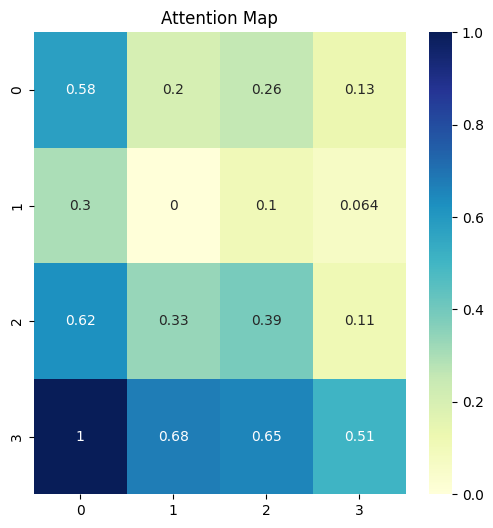

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.8362, grad_fn=<DivBackward1>)


 63%|██████▎   | 19/30 [28:26<16:19, 89.02s/it]

Complete 18 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9852, 0.8506, 0.9884, 0.9163],
         [0.9263, 0.7333, 0.9332, 0.9803],
         [0.9998, 0.9314, 0.9992, 0.8302],
         [0.9955, 0.8864, 0.9972, 0.8842]],

        [[0.8784, 0.9358, 1.0000, 0.9819],
         [0.9406, 0.9792, 0.9858, 0.9995],
         [0.9731, 0.9961, 0.9601, 0.9964],
         [0.8581, 0.9201, 0.9994, 0.9727]],

        [[0.9844, 0.9813, 0.9515, 0.9641],
         [0.9335, 0.9393, 0.9733, 0.9621],
         [0.8793, 0.8868, 0.9343, 0.9179],
         [0.9998, 1.0000, 0.9928, 0.9972]],

        ...,

        [[0.9802, 0.9261, 0.6750, 0.9661],
         [0.9208, 0.8362, 0.5503, 0.8958],
         [0.9937, 0.9547, 0.7265, 0.9847],
         [0.9865, 0.9996, 0.8726, 0.9948]],

        [[0.8770, 0.9805, 0.9945, 0.9864],
         [0.7658, 0.9169, 0.9492, 0.9986],
         [0.9674, 0.9984, 0.9888, 0.9154],
         [0.9841, 0.9909, 0.9742, 0.8829]],

        [[0.9173, 0.8289, 0.7930, 0.9810],
         [0.9117, 0.9733, 0.9866, 0.8097],
         [0.9399, 0.860

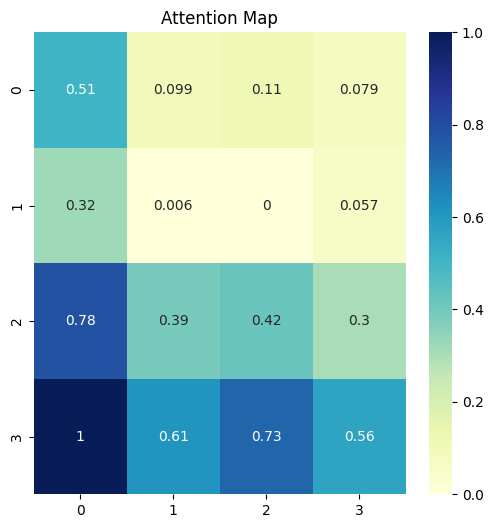

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.7905, grad_fn=<DivBackward1>)


 67%|██████▋   | 20/30 [29:53<14:43, 88.38s/it]

Complete 19 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8433, 0.9885, 0.8791, 0.9332],
         [0.9820, 0.8239, 0.9650, 0.9221],
         [0.9996, 0.8993, 0.9945, 0.9713],
         [1.0000, 0.9076, 0.9964, 0.9759]],

        [[0.9127, 0.7562, 0.7752, 0.9320],
         [0.9949, 0.9153, 0.9279, 0.9988],
         [0.9998, 0.9435, 0.9540, 0.9995],
         [0.9685, 0.8486, 0.8647, 0.9800]],

        [[0.9413, 0.7919, 0.9625, 0.9458],
         [0.9378, 0.9997, 0.9119, 0.9330],
         [0.9710, 0.9957, 0.9519, 0.9676],
         [0.9976, 0.9654, 0.9901, 0.9965]],

        ...,

        [[0.7524, 0.8786, 0.9342, 0.8421],
         [0.9223, 0.9878, 0.9999, 0.9729],
         [0.9998, 0.9657, 0.9215, 0.9827],
         [0.9997, 0.9758, 0.9368, 0.9897]],

        [[0.7968, 0.7173, 0.9176, 0.4715],
         [0.9863, 0.9997, 0.9135, 0.9282],
         [0.9998, 0.9929, 0.9612, 0.8690],
         [0.9684, 0.9937, 0.8767, 0.9564]],

        [[0.7147, 0.8824, 0.5265, 0.9090],
         [0.9276, 0.9977, 0.7824, 1.0000],
         [0.7269, 0.891

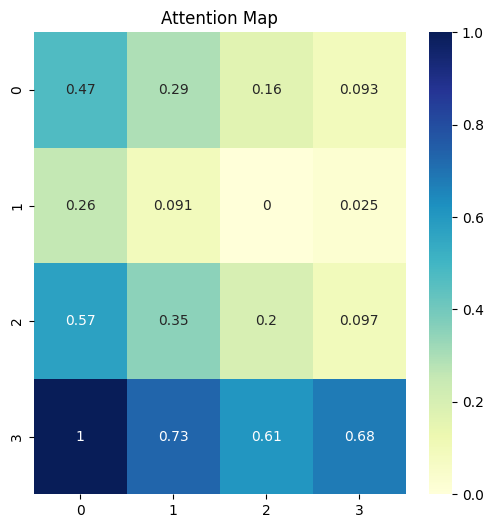

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.7209, grad_fn=<DivBackward1>)


 70%|███████   | 21/30 [31:20<13:09, 87.74s/it]

Complete 20 th
torch.Size([283, 4, 16])
alpha: tensor([[[0.9850, 0.9583, 0.9852, 0.9171],
         [0.9562, 0.9863, 0.9565, 0.9587],
         [0.9699, 0.9764, 0.9702, 0.9429],
         [0.9976, 0.9242, 0.9977, 0.8730]],

        [[0.9980, 0.9012, 0.9748, 0.9997],
         [0.9431, 0.9844, 0.9986, 0.9682],
         [0.9963, 0.9105, 0.9797, 1.0000],
         [0.8774, 1.0000, 0.9756, 0.9142]],

        [[0.9095, 0.9755, 0.9940, 0.9392],
         [0.9623, 0.8868, 0.7128, 0.9377],
         [0.8459, 0.9353, 0.9995, 0.8837],
         [1.0000, 0.9782, 0.8631, 0.9969]],

        ...,

        [[0.6999, 0.8766, 0.6059, 0.7367],
         [0.9170, 0.9964, 0.8488, 0.9395],
         [0.9669, 0.8397, 0.9947, 0.9493],
         [0.9863, 0.9864, 0.9494, 0.9947]],

        [[0.9897, 0.8646, 0.9093, 0.9766],
         [0.9254, 1.0000, 0.9949, 0.9502],
         [0.9629, 0.9928, 0.9999, 0.9800],
         [0.9960, 0.8892, 0.9299, 0.9868]],

        [[0.9673, 0.9498, 0.8706, 0.9134],
         [0.9625, 0.9775, 

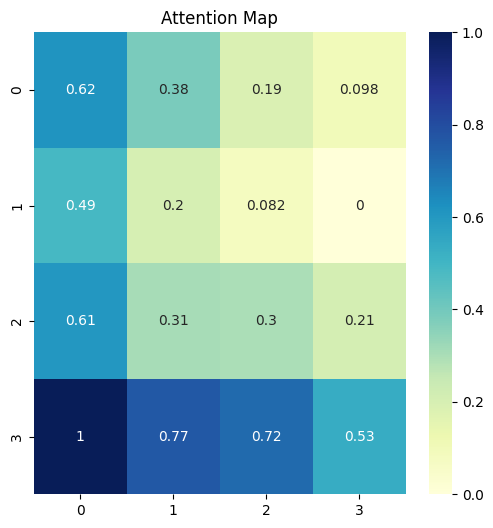

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.6428, grad_fn=<DivBackward1>)


 73%|███████▎  | 22/30 [32:47<11:40, 87.59s/it]

Complete 21 th
torch.Size([283, 4, 16])
alpha: tensor([[[0.9241, 1.0000, 0.8989, 0.9951],
         [0.7080, 0.9097, 0.6696, 0.9455],
         [0.9951, 0.9570, 0.9866, 0.9242],
         [0.9742, 0.9861, 0.9579, 0.9648]],

        [[0.9735, 0.9521, 0.9156, 0.8881],
         [0.9973, 1.0000, 0.9934, 0.9836],
         [0.9845, 0.9954, 0.9999, 0.9969],
         [0.9994, 0.9933, 0.9756, 0.9589]],

        [[0.9702, 0.9533, 0.9950, 0.9591],
         [0.8899, 0.8614, 0.9447, 0.8707],
         [0.9274, 0.9486, 0.8672, 0.9422],
         [0.9999, 0.9987, 0.9875, 0.9996]],

        ...,

        [[0.9885, 0.9999, 0.8495, 0.9993],
         [0.8960, 0.8174, 0.9988, 0.8048],
         [0.9876, 0.9487, 0.9665, 0.9411],
         [0.9925, 0.9991, 0.8633, 0.9977]],

        [[0.9978, 0.9999, 0.9714, 0.9281],
         [0.9803, 0.9895, 0.9325, 0.9683],
         [0.9082, 0.8853, 0.9655, 0.6716],
         [0.8031, 0.7734, 0.8877, 0.5367]],

        [[0.6865, 0.8377, 0.8957, 0.7192],
         [0.8066, 0.9292, 

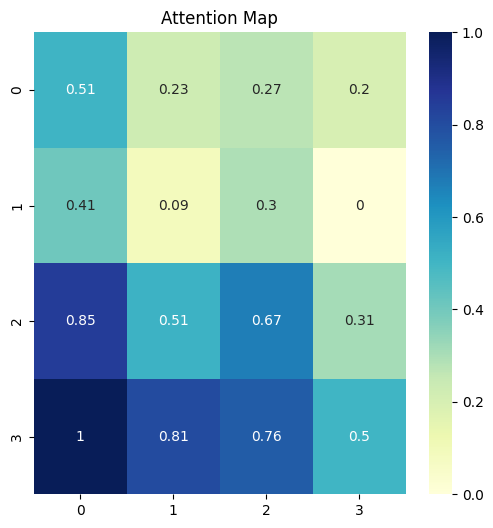

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.5557, grad_fn=<DivBackward1>)


 77%|███████▋  | 23/30 [34:23<10:32, 90.31s/it]

Complete 22 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9998, 0.9279, 0.9965, 0.9906],
         [0.9324, 0.7604, 0.9091, 0.9769],
         [0.9772, 0.8449, 0.9623, 0.9984],
         [0.9755, 0.8410, 0.9602, 0.9979]],

        [[0.7475, 0.9895, 0.9908, 0.8456],
         [0.9257, 0.9750, 0.9730, 0.9783],
         [0.9427, 0.9631, 0.9606, 0.9873],
         [0.9742, 0.9270, 0.9237, 0.9990]],

        [[0.9740, 0.8915, 0.9795, 0.9828],
         [0.9795, 0.9989, 0.8167, 0.9701],
         [0.9008, 0.7789, 0.9997, 0.9179],
         [0.9998, 0.9736, 0.9030, 0.9981]],

        ...,

        [[0.9683, 0.9873, 0.8950, 0.9612],
         [0.8972, 0.9333, 0.7921, 0.8854],
         [0.9994, 0.9915, 0.9838, 1.0000],
         [0.9899, 0.9724, 0.9972, 0.9935]],

        [[0.9565, 0.9951, 0.9868, 0.6876],
         [0.6474, 0.5273, 0.5654, 0.9355],
         [0.9678, 0.9984, 0.9928, 0.7128],
         [0.9394, 0.8585, 0.8873, 0.9774]],

        [[0.9991, 0.9869, 0.9940, 0.9943],
         [0.8294, 0.9204, 0.8997, 0.7953],
         [0.7872, 0.888

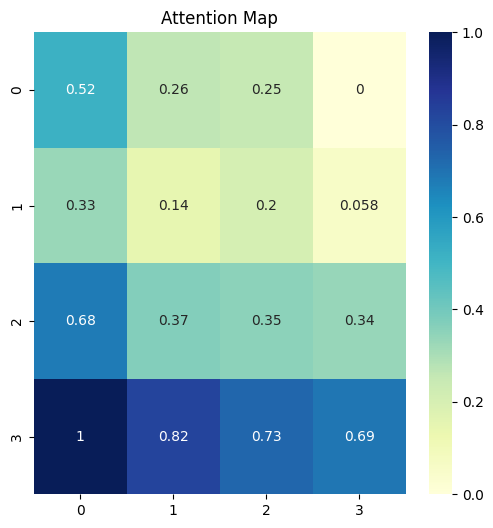

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.4590, grad_fn=<DivBackward1>)


 80%|████████  | 24/30 [36:02<09:16, 92.67s/it]

Complete 23 th
torch.Size([283, 4, 16])
alpha: tensor([[[0.9420, 0.6510, 0.9021, 0.6344],
         [0.9389, 0.9749, 0.9700, 0.9685],
         [0.9962, 0.8852, 0.9998, 0.8729],
         [0.9997, 0.8317, 0.9910, 0.8176]],

        [[0.9063, 0.9801, 0.9107, 0.9854],
         [0.9374, 0.9932, 0.9411, 0.9962],
         [0.9557, 0.9983, 0.9588, 0.9996],
         [0.8775, 0.9646, 0.8824, 0.9718]],

        [[0.9679, 0.9963, 0.9813, 0.9840],
         [0.9090, 0.7386, 0.8834, 0.8769],
         [0.8891, 0.9898, 0.9141, 0.9197],
         [0.9975, 0.9640, 1.0000, 1.0000]],

        ...,

        [[0.9849, 0.9765, 0.9392, 0.9914],
         [0.9132, 0.7151, 0.6339, 0.7648],
         [0.9931, 0.9629, 0.9190, 0.9824],
         [0.9798, 0.9819, 0.9480, 0.9946]],

        [[0.9989, 0.9947, 0.9293, 0.9601],
         [0.5580, 0.5247, 0.8097, 0.7562],
         [0.9686, 0.9536, 0.9844, 0.9968],
         [0.9437, 0.9246, 0.9960, 1.0000]],

        [[0.8569, 0.9285, 0.9416, 0.8188],
         [0.9253, 0.9754, 

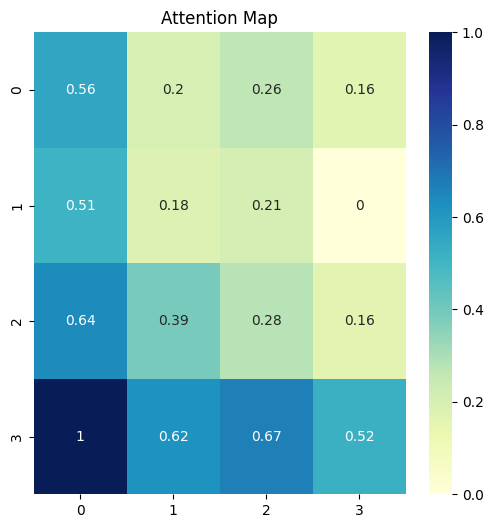

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.4058, grad_fn=<DivBackward1>)


 83%|████████▎ | 25/30 [37:37<07:47, 93.51s/it]

Complete 24 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8950, 0.6976, 0.9297, 0.8806],
         [0.9810, 0.9836, 0.9602, 0.9868],
         [0.9999, 0.9351, 0.9950, 0.9998],
         [0.9748, 0.8333, 0.9907, 0.9669]],

        [[0.8664, 0.9439, 0.8493, 0.8532],
         [0.9890, 0.9989, 0.9830, 0.9845],
         [0.9998, 0.9849, 0.9984, 0.9988],
         [1.0000, 0.9822, 0.9991, 0.9994]],

        [[0.9352, 0.8139, 0.7859, 0.9386],
         [0.8762, 0.7320, 0.7014, 0.8807],
         [0.9498, 0.8369, 0.8100, 0.9528],
         [0.9985, 0.9759, 0.9634, 0.9979]],

        ...,

        [[0.8706, 0.6160, 0.9359, 0.8109],
         [0.6559, 0.8994, 0.5576, 0.7277],
         [0.9958, 0.8599, 0.9975, 0.9776],
         [0.9763, 0.9719, 0.9299, 0.9952]],

        [[0.9527, 0.8414, 0.9290, 0.9977],
         [0.9861, 0.9062, 0.9717, 0.9777],
         [0.9917, 0.9892, 0.9984, 0.8786],
         [0.9729, 0.8778, 0.9541, 0.9895]],

        [[0.8621, 0.8244, 0.5704, 0.7627],
         [0.9489, 0.9229, 0.7034, 0.8757],
         [0.8485, 0.809

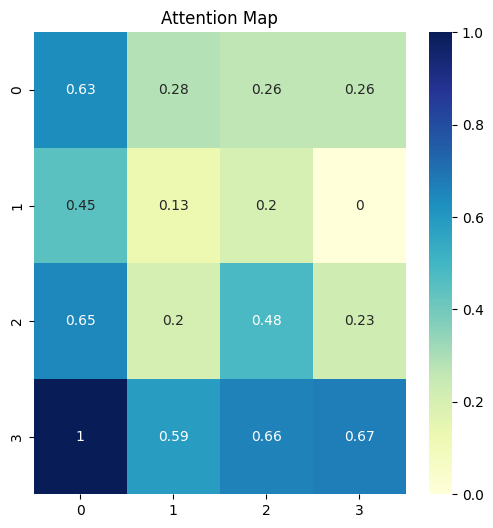

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.3624, grad_fn=<DivBackward1>)


 87%|████████▋ | 26/30 [39:06<06:08, 92.12s/it]

Complete 25 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9998, 0.9105, 0.9995, 0.9962],
         [0.9638, 0.9836, 0.9607, 0.9868],
         [0.9857, 0.8234, 0.9876, 0.9621],
         [0.9766, 0.9725, 0.9741, 0.9940]],

        [[0.9850, 0.9455, 0.9988, 0.9996],
         [0.9962, 0.9973, 0.9532, 0.9737],
         [0.9971, 0.9964, 0.9562, 0.9760],
         [0.9990, 0.9792, 0.9841, 0.9950]],

        [[0.9773, 1.0000, 0.9381, 0.9653],
         [0.8788, 0.9577, 0.9980, 0.8549],
         [0.9258, 0.8317, 0.6281, 0.9435],
         [0.9997, 0.9716, 0.8365, 0.9997]],

        ...,

        [[0.9450, 0.9918, 0.6652, 0.9712],
         [0.7195, 0.4428, 0.1221, 0.6634],
         [0.9072, 0.9997, 0.7273, 0.9416],
         [0.9770, 0.9694, 0.5922, 0.9927]],

        [[0.9986, 0.9976, 0.9811, 0.9862],
         [0.9530, 0.9581, 0.8559, 0.9811],
         [0.9278, 0.9341, 0.8176, 0.9636],
         [0.9990, 0.9981, 0.9794, 0.9875]],

        [[0.9951, 0.8414, 0.9916, 0.9828],
         [0.9991, 0.8688, 0.9826, 0.9917],
         [0.7428, 0.960

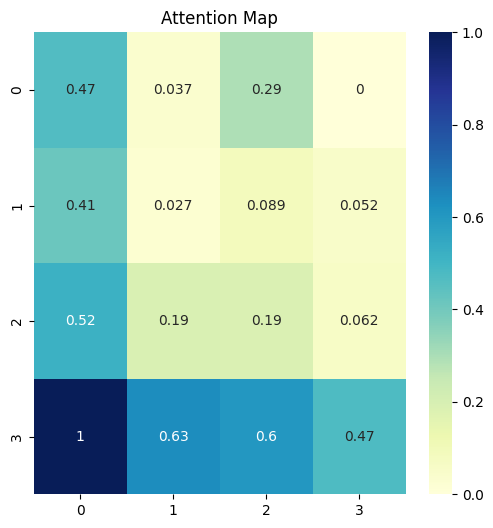

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.3321, grad_fn=<DivBackward1>)


 90%|█████████ | 27/30 [40:31<04:29, 89.94s/it]

Complete 26 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9794, 0.9986, 0.9892, 0.9893],
         [0.9507, 0.9982, 0.9665, 0.9666],
         [0.9762, 0.8925, 0.9625, 0.9624],
         [0.9786, 0.8974, 0.9655, 0.9654]],

        [[0.8870, 0.9187, 0.7613, 0.9044],
         [0.9911, 0.9778, 0.9934, 0.9847],
         [0.9810, 0.9632, 0.9986, 0.9722],
         [0.9618, 0.9800, 0.8699, 0.9721]],

        [[0.9255, 0.9021, 0.6274, 0.9434],
         [0.9692, 0.9821, 0.9496, 0.9552],
         [0.8650, 0.8358, 0.5397, 0.8885],
         [0.9997, 0.9993, 0.8604, 0.9971]],

        ...,

        [[0.8616, 0.9274, 0.6797, 0.7315],
         [0.9169, 0.9670, 0.7551, 0.8034],
         [0.9808, 0.9391, 0.9908, 0.9989],
         [0.9890, 0.9542, 0.9832, 0.9954]],

        [[0.9012, 0.9782, 0.7375, 0.5420],
         [0.5206, 0.3812, 0.7155, 0.8860],
         [0.9201, 0.9870, 0.7648, 0.5710],
         [0.9639, 0.8747, 0.9986, 0.9305]],

        [[0.8107, 0.9063, 0.5041, 0.8549],
         [0.9619, 0.8899, 0.9707, 0.9350],
         [0.9058, 0.810

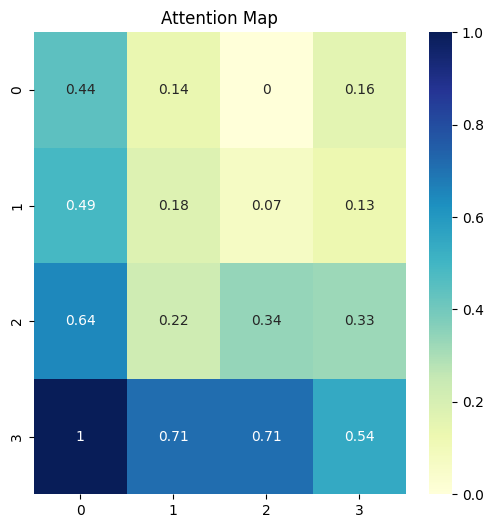

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.3225, grad_fn=<DivBackward1>)


 93%|█████████▎| 28/30 [41:57<02:57, 88.76s/it]

Complete 27 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8551, 0.9980, 0.8885, 0.7061],
         [0.9594, 0.6602, 0.9369, 0.9999],
         [0.9832, 0.9080, 0.9939, 0.9001],
         [0.9825, 0.7195, 0.9665, 0.9962]],

        [[0.9954, 0.8787, 0.8906, 0.9897],
         [0.9850, 0.9112, 0.9216, 0.9978],
         [0.9872, 0.9059, 0.9165, 0.9968],
         [0.9489, 0.9612, 0.9682, 0.9965]],

        [[0.9990, 0.9830, 0.9858, 1.0000],
         [0.9536, 0.8655, 0.9833, 0.9408],
         [0.9411, 0.8462, 0.9753, 0.9269],
         [0.9988, 0.9621, 0.9971, 0.9960]],

        ...,

        [[0.8969, 0.8837, 0.9999, 0.9712],
         [0.9171, 0.9285, 0.6709, 0.8144],
         [0.9807, 0.9743, 0.9615, 0.9996],
         [0.9961, 0.9930, 0.9269, 0.9907]],

        [[0.8911, 0.8426, 0.7380, 0.9198],
         [0.6875, 0.6243, 0.5074, 0.7295],
         [0.9950, 0.9792, 0.9234, 0.9996],
         [0.9865, 0.9643, 0.8980, 0.9956]],

        [[0.9960, 0.9627, 0.9784, 0.9928],
         [0.9013, 0.9644, 0.7526, 0.9138],
         [0.7849, 0.878

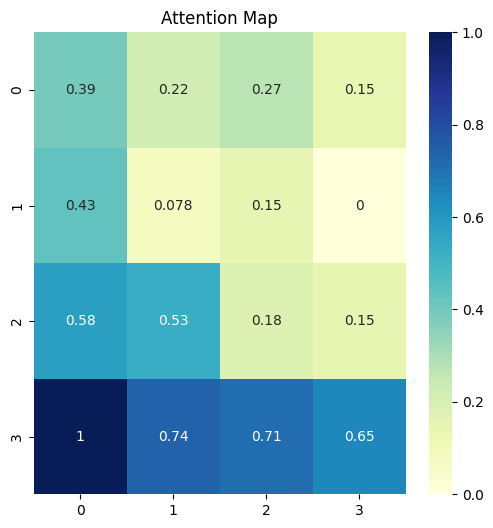

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.3161, grad_fn=<DivBackward1>)


 97%|█████████▋| 29/30 [43:21<01:27, 87.51s/it]

Complete 28 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9886, 0.7572, 0.9882, 0.8436],
         [0.7467, 0.9856, 0.7483, 0.9462],
         [0.9732, 0.7103, 0.9726, 0.8018],
         [0.9711, 0.7049, 0.9705, 0.7969]],

        [[0.9832, 0.9454, 0.9733, 0.9995],
         [0.9948, 0.9988, 0.9986, 0.9683],
         [0.9998, 0.9917, 0.9996, 0.9851],
         [0.9988, 0.9949, 1.0000, 0.9800]],

        [[0.9991, 0.9922, 0.8811, 0.9989],
         [0.9304, 0.8608, 0.9968, 0.9318],
         [0.8438, 0.7547, 0.9926, 0.8458],
         [0.9979, 0.9735, 0.9244, 0.9982]],

        ...,

        [[0.9061, 0.9430, 0.6536, 0.9493],
         [0.6402, 0.5788, 0.8970, 0.5666],
         [0.9320, 0.9632, 0.6947, 0.9683],
         [0.9985, 0.9989, 0.8678, 0.9978]],

        [[0.9229, 0.9984, 0.7207, 0.7782],
         [0.7934, 0.5239, 0.9638, 0.9329],
         [0.8767, 0.9984, 0.6539, 0.7141],
         [0.9781, 0.8006, 0.9805, 0.9953]],

        [[0.9997, 0.9682, 0.9920, 0.9925],
         [0.7947, 0.9233, 0.8704, 0.8684],
         [0.9395, 0.997

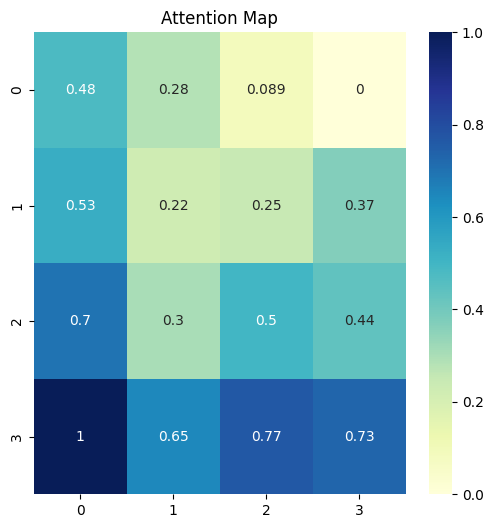

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(725.3099, grad_fn=<DivBackward1>)


100%|██████████| 30/30 [44:45<00:00, 89.52s/it]

Complete 29 th


In [20]:
for iepoch in tqdm(range(30)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = binary_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()
    print("Complete "+str(iepoch)+" th")

torch.Size([78, 4, 16])
alpha: tensor([[[0.9324, 0.9693, 0.7342, 0.8715],
         [0.9520, 0.9531, 0.7685, 0.8979],
         [0.9869, 0.7343, 0.9693, 0.9999],
         [0.9969, 0.8619, 0.8867, 0.9742]],

        [[0.8979, 0.8744, 0.9648, 0.9989],
         [0.9854, 0.9931, 0.9344, 0.7919],
         [0.9823, 0.9709, 1.0000, 0.9494],
         [0.9953, 0.9990, 0.9577, 0.8308]],

        [[0.9745, 0.9143, 0.9790, 0.9994],
         [0.9998, 0.9846, 0.9991, 0.9610],
         [0.9933, 0.9524, 0.9955, 0.9894],
         [0.7811, 0.6675, 0.7926, 0.9073]],

        ...,

        [[0.7962, 0.7265, 0.8644, 0.8931],
         [0.8782, 0.8180, 0.9323, 0.9531],
         [0.9865, 0.9591, 0.9996, 0.9994],
         [0.9989, 0.9855, 0.9961, 0.9884]],

        [[0.7414, 0.8363, 0.8019, 0.7218],
         [0.9995, 0.9790, 0.9903, 1.0000],
         [0.7259, 0.6211, 0.6613, 0.7454],
         [0.9979, 0.9939, 0.9990, 0.9952]],

        [[0.9926, 0.9659, 0.9569, 0.9933],
         [0.9854, 0.9774, 0.9417, 0.9864],

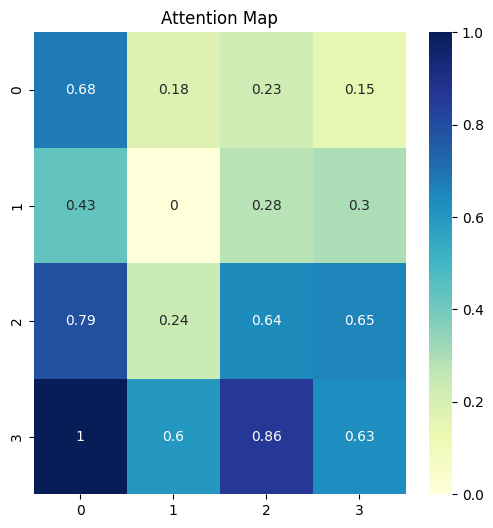

Q_output size: torch.Size([4, 78, 4])
K_output size: torch.Size([4, 78, 4])
V_output size: torch.Size([78, 4, 16])

Accuracy: 1.0

Loss: 164.04408264160156

AUROC: 1.0



/tmp/ipykernel_7033/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [21]:
from sklearn.metrics import roc_auc_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)
for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Calculate AUROC
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy
auroc = roc_auc_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')

-----------------------------------------